In [ ]:
import pandas as pd

# Load your data into a DataFrame
df = pd.read_csv('Final data 1.csv')
# df.head()

# Convert DATE column to datetime using the correct format
df['DATE'] = pd.to_datetime(df['DATE'], format='%d-%m-%Y', errors='coerce')


In [ ]:
df.set_index('DATE', inplace=True)


In [ ]:
print(df.columns)


Index(['BILL NO.', 'PARTY NAME', 'BILL AMT.', 'TAXABLE', 'TAX', 'TAX FREE',
       'EXEMPTED', 'R.OFF'],
      dtype='object')


## Customer Lifetime Value (CLV)

Objective: Determine the long-term value of different customer segments.

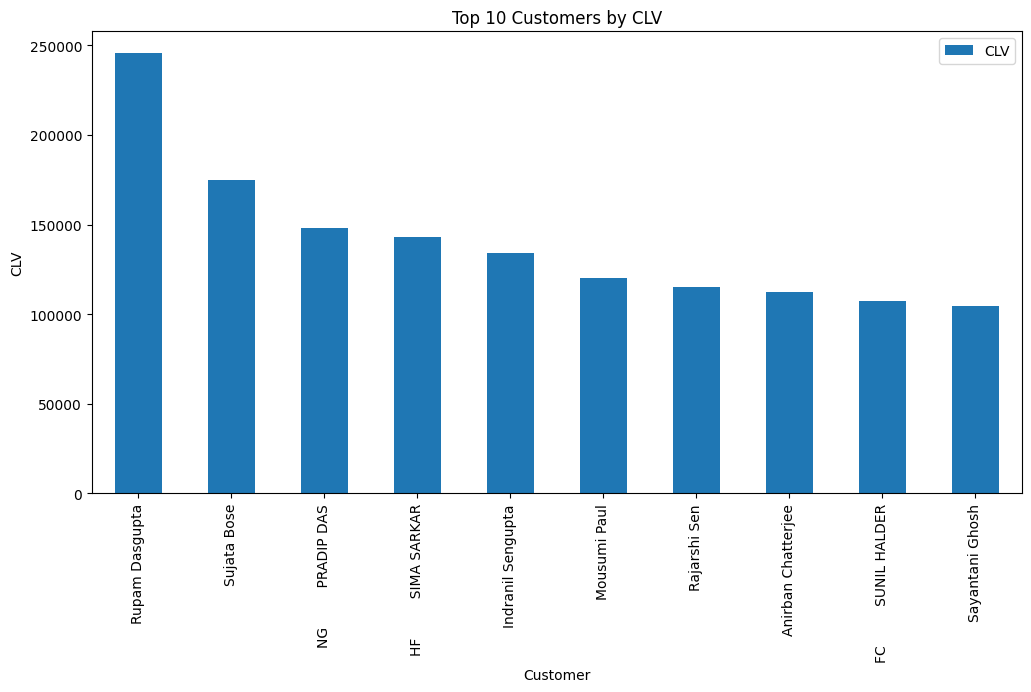

In [ ]:
df['CLV'] = df.groupby('PARTY NAME')['BILL AMT.'].transform('sum')
clv_summary = df[['PARTY NAME', 'CLV']].drop_duplicates().sort_values(by='CLV', ascending=False)

clv_summary.head(10).plot(kind='bar', x='PARTY NAME', y='CLV', figsize=(12, 6))
plt.title('Top 10 Customers by CLV')
plt.xlabel('Customer')
plt.ylabel('CLV')
plt.show()

## Correlation matrix
Objective: Identify relationships between different variables in your dataset.

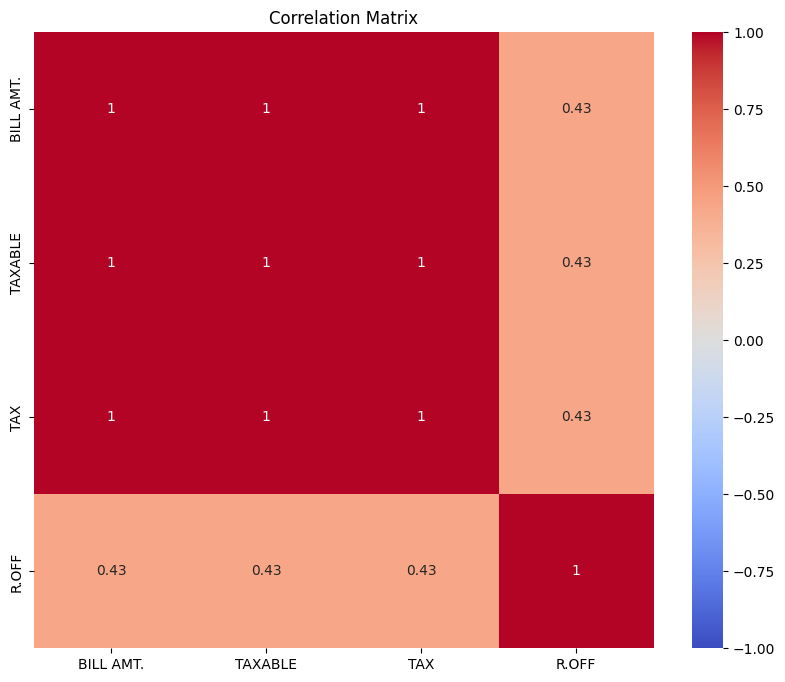

In [ ]:
correlation_matrix = df[['BILL AMT.', 'TAXABLE', 'TAX', 'R.OFF']].corr()

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


## Churn Analysis

<ipython-input-25-c8d11dfa40cd>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=party_summary, x='CHURNED', palette='viridis')


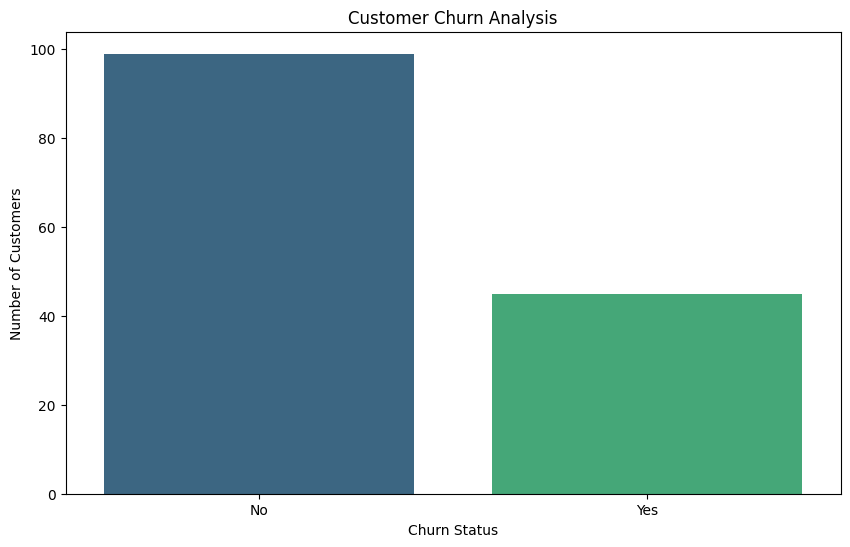

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv('Final data 1.csv')

# Convert DATE column to datetime with error handling
data['DATE'] = pd.to_datetime(data['DATE'], dayfirst=True, errors='coerce')

# Drop rows with invalid date formats
data = data.dropna(subset=['DATE'])

# Filter data for the specified date range
start_date = '2021-04-01'
end_date = '2022-03-31'
data = data[(data['DATE'] >= start_date) & (data['DATE'] <= end_date)]

# Aggregate data by PARTY NAME to get total purchase count and amount
party_summary = data.groupby('PARTY NAME').agg({
    'BILL NO.': 'count',
    'BILL AMT.': 'sum'
}).reset_index()

# Define churn based on no purchases in the last quarter of the period
last_quarter_start = '2021-12-01'
last_quarter_end = '2022-03-31'
last_quarter_data = data[(data['DATE'] >= last_quarter_start) & (data['DATE'] <= last_quarter_end)]
churned_parties = set(party_summary['PARTY NAME']) - set(last_quarter_data['PARTY NAME'])

# Add churn status to the summary
party_summary['CHURNED'] = party_summary['PARTY NAME'].apply(lambda x: 'Yes' if x in churned_parties else 'No')

# Visualize churn analysis
plt.figure(figsize=(10, 6))
sns.countplot(data=party_summary, x='CHURNED', palette='viridis')
plt.title('Customer Churn Analysis')
plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
plt.show()

## RFM Analysis

In [ ]:
import pandas as pd
df = pd.read_csv('Final data 1.csv')

# Convert 'DATE' to datetime format
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce', format='%d-%m-%Y')

# Drop rows with missing 'DATE', 'PARTY NAME', or 'BILL AMT.'
df.dropna(subset=['DATE', 'PARTY NAME', 'BILL AMT.'], inplace=True)

# df.head()
# Assume today's date for Recency calculation
today_date = pd.to_datetime('2024-08-15')

# Calculate RFM metrics
rfm_table = df.groupby('PARTY NAME').agg({
    'DATE': lambda x: (today_date - x.max()).days,  # Recency
    'BILL NO.': 'count',  # Frequency
    'BILL AMT.': 'sum'  # Monetary
}).reset_index()

rfm_table.columns = ['Party Name', 'Recency', 'Frequency', 'Monetary']

# Scoring RFM values
# Recency: Using qcut for quantiles
rfm_table['R_Score'] = pd.qcut(rfm_table['Recency'], 5, labels=[5, 4, 3, 2, 1])

# Frequency and Monetary: Using cut with custom bins
frequency_bins = [0, 1, 2, 3, 4, rfm_table['Frequency'].max()]
monetary_bins = [0, 1000, 3000, 5000, 10000, rfm_table['Monetary'].max()]

rfm_table['F_Score'] = pd.cut(rfm_table['Frequency'], bins=frequency_bins, labels=[1, 2, 3, 4, 5], include_lowest=True)
rfm_table['M_Score'] = pd.cut(rfm_table['Monetary'], bins=monetary_bins, labels=[1, 2, 3, 4, 5], include_lowest=True)

# Calculate the RFM Score
rfm_table['RFM_Score'] = rfm_table[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# Display the RFM table
print(rfm_table.head())

# Optionally, save the RFM table to a CSV file
rfm_table.to_csv('rfm_results.csv', index=False)

# Define segments based on RFM scores
def segment_customer(row):
    if row['R_Score'] == 5 and row['F_Score'] == 5 and row['M_Score'] == 5:
        return 'Champions'
    elif row['R_Score'] <= 3 and row['F_Score'] >= 4:
        return 'Loyal Customers'
    elif row['R_Score'] <= 4 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
        return 'Potential Loyalists'
    elif row['R_Score'] == 5 and row['F_Score'] <= 2:
        return 'New Customers'
    elif row['R_Score'] >= 4 and row['F_Score'] <= 2:
        return 'At Risk'
    else:
        return 'Lost'

# Apply segmentation
rfm_table['Segment'] = rfm_table.apply(segment_customer, axis=1)

# Display the segmented RFM table
print(rfm_table.head())

# Optionally, save the segmented RFM table to a CSV file
rfm_table.to_csv('rfm_segmented_results.csv', index=False)


           Party Name  Recency  Frequency  Monetary R_Score F_Score M_Score  \
0          Amrita Sen      958          1    4435.0       3       1       3   
1        Anindita Ray      954          4   47167.0       3       4       5   
2  Anirban Chatterjee      871          7  112687.0       5       5       5   
3    Anjana Mukherjee      911          3   40221.0       4       3       5   
4        Antara Ghosh      920          4   51079.0       4       4       5   

   RFM_Score  
0          7  
1         12  
2         15  
3         12  
4         13  
           Party Name  Recency  Frequency  Monetary R_Score F_Score M_Score  \
0          Amrita Sen      958          1    4435.0       3       1       3   
1        Anindita Ray      954          4   47167.0       3       4       5   
2  Anirban Chatterjee      871          7  112687.0       5       5       5   
3    Anjana Mukherjee      911          3   40221.0       4       3       5   
4        Antara Ghosh      920          

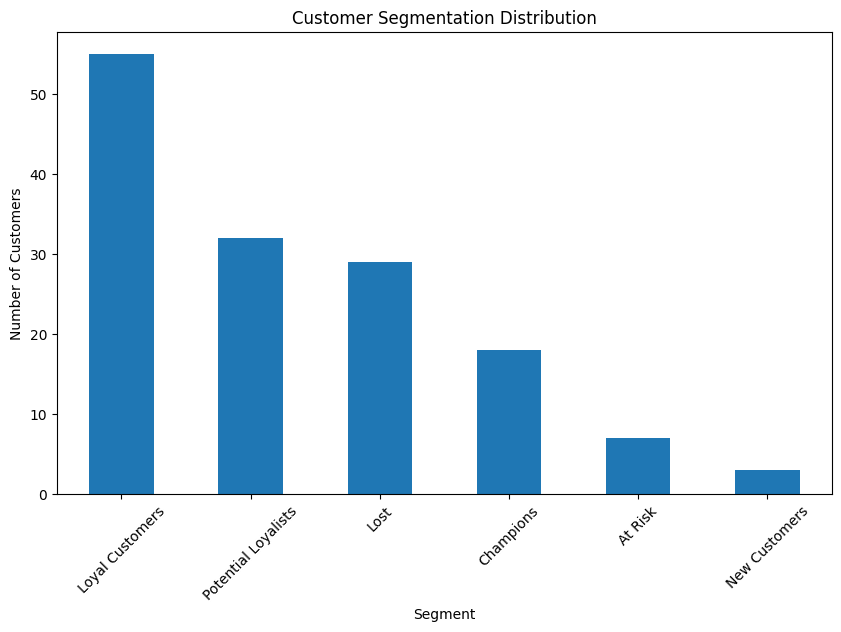

In [ ]:
import matplotlib.pyplot as plt

# Count the number of customers in each segment
segment_counts = rfm_table['Segment'].value_counts()

# Plot the distribution of segments
plt.figure(figsize=(10, 6))
segment_counts.plot(kind='bar')
plt.title('Customer Segmentation Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


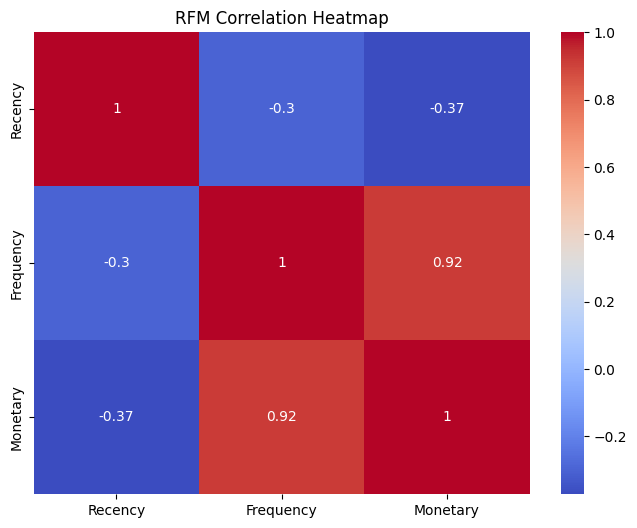

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(rfm_table[['Recency', 'Frequency', 'Monetary']].corr(), annot=True, cmap='coolwarm')
plt.title('RFM Correlation Heatmap')
plt.show()

## Inventory Management

In [ ]:
import pandas as pd

# Load dataset
data = pd.read_csv('Final data 1.csv')

# Convert DATE column to datetime, allowing for mixed or incorrect formats
data['DATE'] = pd.to_datetime(data['DATE'], dayfirst=True, errors='coerce')

# Drop rows with invalid dates
data.dropna(subset=['DATE'], inplace=True)

# Set DATE as the index
data.set_index('DATE', inplace=True)

# Check if the index is now a DatetimeIndex
print("Index type:", type(data.index))

# Aggregate sales by month
monthly_sales = data['BILL AMT.'].resample('M').sum()

# Display the top months by sales
top_months = monthly_sales.sort_values(ascending=False).head(11)  # Top 12 months
print("Top 12 Selling Months:")
print(top_months)


Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Top 12 Selling Months:
DATE
2021-07-31    906731.0
2021-06-30    906525.0
2021-04-30    847074.0
2021-05-31    822663.0
2022-03-31    728248.0
2022-01-31    716004.0
2021-11-30    714516.0
2021-12-31    694398.0
2021-10-31    651106.0
2022-02-28    611877.0
2021-08-31    379203.0
Name: BILL AMT., dtype: float64


In [ ]:
# Identify the peak sales months
peak_months = top_months.index.strftime('%B %Y')
print("Peak Sales Months:")
print(peak_months)


Peak Sales Months:
Index(['July 2021', 'June 2021', 'April 2021', 'May 2021', 'March 2022',
       'January 2022', 'November 2021', 'December 2021', 'October 2021',
       'February 2022', 'August 2021'],
      dtype='object', name='DATE')


Peak Sales Months:
Index(['July 2021', 'June 2021', 'April 2021', 'May 2021', 'March 2022',
       'January 2022', 'November 2021', 'December 2021', 'October 2021',
       'February 2022', 'August 2021'],
      dtype='object', name='DATE')

Sales Summary by Month:
             Sales
Month             
July      906731.0
June      906525.0
April     847074.0
May       822663.0
March     728248.0
January   716004.0
November  714516.0
December  694398.0
October   651106.0
February  611877.0
August    379203.0


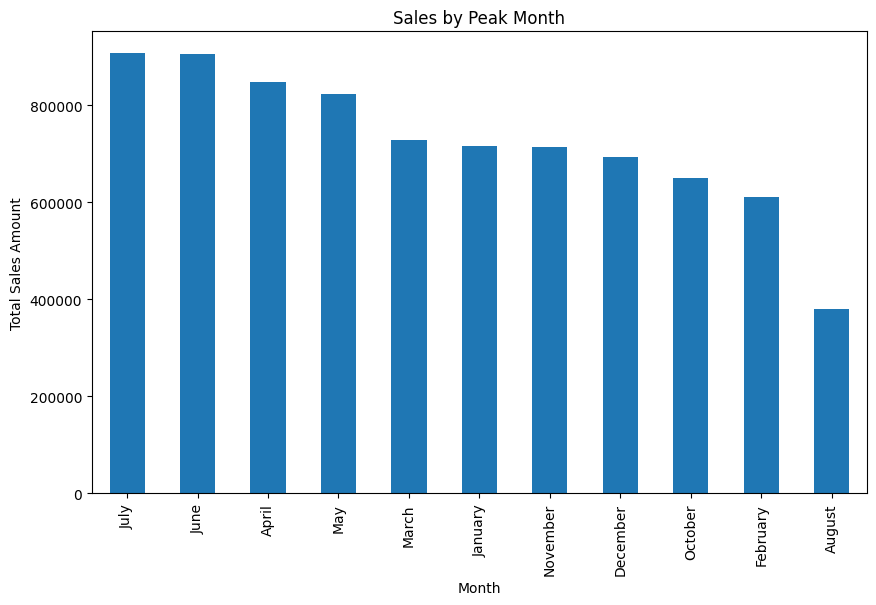

In [ ]:
import pandas as pd

# Assuming 'top_months' contains the top 11 selling months
# top_months = monthly_sales.sort_values(ascending=False).head(11)

# Identify the peak sales months
peak_months = top_months.index.strftime('%B %Y')
print("Peak Sales Months:")
print(peak_months)

# Group by Month to see if certain months are repeatedly high
peak_months_df = pd.DataFrame({'Month': top_months.index.month_name(), 'Sales': top_months.values})
monthly_sales_summary = peak_months_df.groupby('Month').sum().sort_values(by='Sales', ascending=False)

print("\nSales Summary by Month:")
print(monthly_sales_summary)

# Visualizing the peak sales months
monthly_sales_summary.plot(kind='bar', figsize=(10, 6), legend=False)
plt.title('Sales by Peak Month')
plt.ylabel('Total Sales Amount')
plt.xlabel('Month')
plt.show()
